$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$
# ACISDetector With CSV
<a id=ACISDetectorCSV></a>
In this part, we will examine our algorithms to classify binaries. Additionally, we'll write training loops and implement a modular model trainer. We'll use a few configurations for classifying architecture and instruction set with [isadetect]( https://github.com/kairis/isadetect) CSV Datasets.


In [1]:
import os
import re
import sys
import glob
import numpy as np
import matplotlib.pyplot as plt
import torch

%matplotlib inline
%load_ext autoreload
%autoreload 2

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


## Architecture and instruction set
<a id=arch_is></a>
<!--isadetect 

@inproceedings{kairajarvi2020isadetect,
author={Kairaj\"arvi, Sami and Costin, Andrei and H\"am\"al\"ainen, Timo},
title={{ISAdetect: Usable Automated Detection of CPU Architecture and Endianness for Executable Binary Files and Object Code}},
booktitle={Proceedings of the Tenth ACM Conference on Data and Application Security and Privacy},
year={2020},
url="https://doi.org/10.1145/3374664.3375742"
}
-->

In [3]:
import isadetect.helpers as isa_api 
import src.arch_classifier as arch_api
import src.hyperparams as hp
from src.binary_dataset import FeatureDataset,DatasetToTuple
import src.arch_trainer as training


## Preprocessing 

In [4]:
import pathlib
import urllib
import shutil
DOWNLOAD_URL = 'https://github.com/kfirgirstein/ACISDetector/releases/download/Dataset/ISAdetect_only_code_sections_features.csv'
DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')

def download_dataset(out_path=DATA_DIR, url=DOWNLOAD_URL, force=False):
    pathlib.Path(out_path).mkdir(exist_ok=True)
    out_filename = os.path.join(out_path, os.path.basename(url))

    if os.path.isfile(out_filename) and not force:
        print(f'Dataset file {out_filename} exists, skipping download.')
    else:
        print(f'Downloading {url}...')
        with urllib.request.urlopen(url) as response, open(out_filename, 'wb') as out_file:
            shutil.copyfileobj(response, out_file)
        print(f'Saved to {out_filename}.')
    return out_filename

DATASET_FILE = download_dataset()

Saved to /home/lusky/.pytorch-datasets/ISAdetect_only_code_sections_features.csv.


In [5]:
binary_dataset = FeatureDataset(DATASET_FILE)
N = len(binary_dataset)
batch_size = 32
print(f'features length: {N}')

train_length = int(0.7* N)
test_length = N - train_length
ds_train,ds_test = torch.utils.data.random_split(binary_dataset,(train_length,test_length))

print(f'Train: {len(ds_train)} samples')
print(f'Test: {len(ds_test)} samples')

dl_train = torch.utils.data.DataLoader(ds_train,batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(ds_test,batch_size=batch_size, shuffle=True)

x0,y0 = ds_train[0]
dataset_shape = (x0.shape if x0.dim() > 0 else 1),(y0.shape if y0.dim() > 0 else 1)
print('input size =', dataset_shape[0], "X",dataset_shape[1] )

features length: 66685
Train: 46679 samples
Test: 20006 samples
input size = torch.Size([293]) X 1


## Training
<a id=part2_3></a>

in order to plot our result and to compare them, we will use plot.py
and then we'll use the following function to load multiple experiment results and plot them together.

In [6]:
from jupyter_utils.plot import plot_fit, plot_exp_results, plot_residuals
fig = None
fit_res = []

num_classes = 24
in_size = dataset_shape[0][0]
help(plot_fit)

Help on function plot_fit in module jupyter_utils.plot:

plot_fit(fit_res: src.train_results.FitResult, fig=None, log_loss=False, legend=None)
    Plots a FitResult object.
    Creates four plots: train loss, test loss, train acc, test acc.
    :param fit_res: The fit result to plot.
    :param fig: A figure previously returned from this function. If not None,
        plots will the added to this figure.
    :param log_loss: Whether to plot the losses in log scale.
    :param legend: What to call this FitResult in the legend.
    :return: The figure.



In [ ]:
rf_hp = hp.random_forest_hp()
print(rf_hp)

_randomForest = arch_api.RandomForest(in_estimators = rf_hp["estimators"] , in_max_depth = batch_size,random_state= rf_hp["random_state"] , n_jobs = rf_hp["n_jobs"])
print(_randomForest)
rf_dataset  = binary_dataset[ds_train.indices]
_randomForest.fit(*rf_dataset)

print("RandomForest modle is fiting now!")

{'estimators': 100, 'random_state': 0, 'n_jobs': -1}
RandomForest(estimators=100,max_depth=32,random_state=0)


In [8]:
loss_fn = torch.nn.MSELoss()
rf_ev = _randomForest.evaluate(dl_test,loss_fn)
print("Avg Loss: ",sum(rf_ev['losses'])/len(rf_ev['losses']),"Accuracy: ",rf_ev['accuracy'])

0 / 626 : Loss  0.0 , Num Correct  32
100 / 626 : Loss  0.0 , Num Correct  3227
200 / 626 : Loss  0.0 , Num Correct  6424
300 / 626 : Loss  0.0 , Num Correct  9620
400 / 626 : Loss  0.0 , Num Correct  12817
500 / 626 : Loss  0.0 , Num Correct  16014
600 / 626 : Loss  0.0 , Num Correct  19208
Avg Loss:  0.021665335463258786 Accuracy:  99.8700389883035


In [9]:
_isa_mlp = arch_api.ISADetectLogisticRegression(in_size,num_classes)
optimizer = torch.optim.Adam(_isa_mlp.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()
trainer = training.ArchTrainer(_isa_mlp, loss_fn, optimizer, device)
print(_isa_mlp)

fit_res.append({"legend":"ISADetectLogisticRegression","result":trainer.fit(dl_train,dl_test,num_epochs = 10,print_every=100)})
print("ISADetectLogisticRegression modle is fiting now!")

ISADetectLogisticRegression(
  (classifier): Sequential(
    (0): Linear(in_features=293, out_features=24, bias=True)
    (1): Softmax(dim=1)
  )
)
--- EPOCH 1/10 ---
test_batch (Avg. Loss 2.451, Accuracy 88.5): 100%|██████████████████████████████████████████████████████████████| 626/626 [00:03<00:00, 206.10it/s]
--- EPOCH 10/10 ---
test_batch (Avg. Loss 2.295, Accuracy 96.9): 100%|██████████████████████████████████████████████████████████████| 626/626 [00:03<00:00, 203.01it/s]
ISADetectLogisticRegression modle is fiting now!


In [10]:
mlp_hp = hp.mlp_hp()
print(mlp_hp)

_mlp = arch_api.MLP(in_size,num_classes,mlp_hp['hidden_size'])
optimizer = torch.optim.Adam(_mlp.parameters(), lr=mlp_hp['lr'])
loss_fn = torch.nn.CrossEntropyLoss()
trainer = training.ArchTrainer(_mlp, loss_fn, optimizer, device)
print(_mlp)
fit_res.append({"legend":"MLP","result":trainer.fit(dl_train,dl_test,num_epochs = 10,print_every=2)})
print("MLP modle is fiting now!")

{'hidden_size': [100], 'lr': 0.01, 'reg': 0.05}
MLP(
  (classifier): Sequential(
    (0): Linear(in_features=293, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=24, bias=True)
    (3): Softmax(dim=1)
  )
)
--- EPOCH 1/10 ---
test_batch (Avg. Loss 2.369, Accuracy 88.4): 100%|██████████████████████████████████████████████████████████████| 626/626 [00:02<00:00, 213.95it/s]
--- EPOCH 3/10 ---
test_batch (Avg. Loss 2.324, Accuracy 92.3): 100%|██████████████████████████████████████████████████████████████| 626/626 [00:02<00:00, 229.02it/s]
--- EPOCH 5/10 ---
test_batch (Avg. Loss 2.278, Accuracy 96.9): 100%|██████████████████████████████████████████████████████████████| 626/626 [00:02<00:00, 214.65it/s]
--- EPOCH 7/10 ---
test_batch (Avg. Loss 2.278, Accuracy 96.9): 100%|██████████████████████████████████████████████████████████████| 626/626 [00:04<00:00, 142.42it/s]
--- EPOCH 9/10 ---
test_batch (Avg. Loss 2.278, Accuracy 96.9): 100%|█████████████

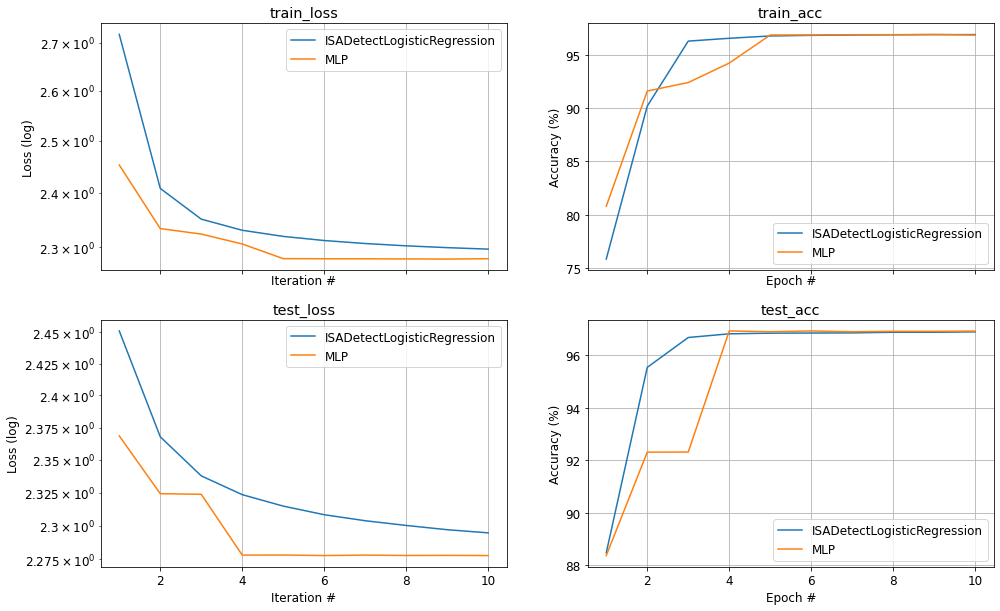

In [11]:
for elem in fit_res:
    fig, axes = plot_fit(elem['result'], fig, legend = elem['legend'],log_loss=True)
fig = []